In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [276]:
data = pd.read_csv("car_fuel_efficiency.csv")
sel_cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
sel_data = data[sel_cols]
sel_data.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


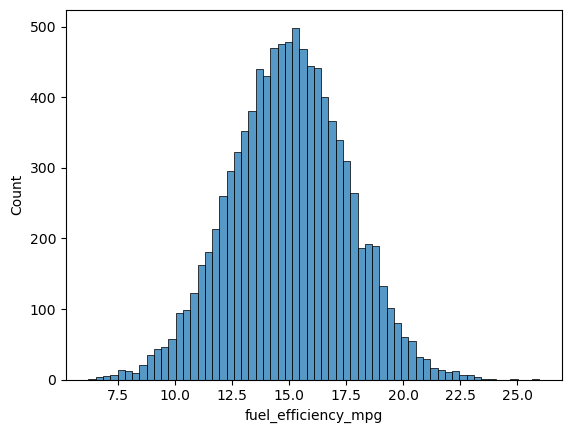

In [203]:
sns.histplot(data = sel_data['fuel_efficiency_mpg'])
plt.show()


Data doesnt have a long tail and follows the curve of normal distribution.

In [204]:
sel_data.isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

"horsepower" column has empty cells.

In [205]:
sel_data['horsepower'].median()

149.0

In [217]:
np.random.seed(42)
n = len(sel_data)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)
shuf_data = sel_data.iloc[idx]

xtrain = shuf_data.iloc[:n_train]
xval = shuf_data.iloc[n_train : n_train + n_val]
xtest = shuf_data.iloc[n_train + n_val:]

xtrain = xtrain.reset_index(drop=True)
xval = xval.reset_index(drop=True)
xtest = xtest.reset_index(drop=True)

ytrain = xtrain.fuel_efficiency_mpg.values
yval = xval.fuel_efficiency_mpg.values
ytest = xtest.fuel_efficiency_mpg.values

ytrainlog = np.log1p(xtrain.fuel_efficiency_mpg.values)
yvallog = np.log1p(xval.fuel_efficiency_mpg.values)
ytestlog = np.log1p(xtest.fuel_efficiency_mpg.values)

del xtrain["fuel_efficiency_mpg"]
del xtest["fuel_efficiency_mpg"]
del xval["fuel_efficiency_mpg"]



In [218]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [219]:
xtrainmean = xtrain.copy()
xtrainzero = xtrain.copy()

xvalmean = xval.copy()
xvalzero = xval.copy()

xtrainzero.fillna(0, inplace= True)
xtrainmean.fillna(xtrain.horsepower.mean(), inplace= True)

xvalzero.fillna(0, inplace= True)
xvalmean.fillna(xtrain.horsepower.mean(), inplace= True)



In [226]:
def predict(X, w):
    return w[0] + X.dot(w[1])

In [227]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [228]:
# Calculating RMSE for zero and mean with log transformation
wZero = train_linear_regression(xtrainzero, ytrainlog)
wMean = train_linear_regression(xtrainmean, ytrainlog)

predszero = predict(xvalzero, wZero)
predsmean = predict(xvalmean, wMean)

predszero_original = np.expm1(predszero)
rmse_originalzero = rmse(yval, predszero_original)

predsmean_original = np.expm1(predsmean)
rmse_originalmean = rmse(yval, predsmean_original)

print(f"RMSE for Zero: {round(rmse_originalzero,2)}")
print(f"RMSE for Mean: {round(rmse_originalmean,2)}")

RMSE for Zero: 0.62
RMSE for Mean: 0.58


In [234]:
# Calculating RMSE for zero and mean without log transformation

wZero = train_linear_regression(xtrainzero, ytrain)
wMean = train_linear_regression(xtrainmean, ytrain)

predszero = predict(xvalzero, wZero)
predsmean = predict(xvalmean, wMean)

# predszero_original = np.expm1(predszero)
rmse_originalzero = rmse(yval, predszero)

# predsmean_original = np.expm1(predsmean)
rmse_originalmean = rmse(yval, predsmean)

print(f"RMSE for Zero: {round(rmse_originalzero,2)}")
print(f"RMSE for Mean: {round(rmse_originalmean,2)}")

RMSE for Zero: 0.52
RMSE for Mean: 0.46


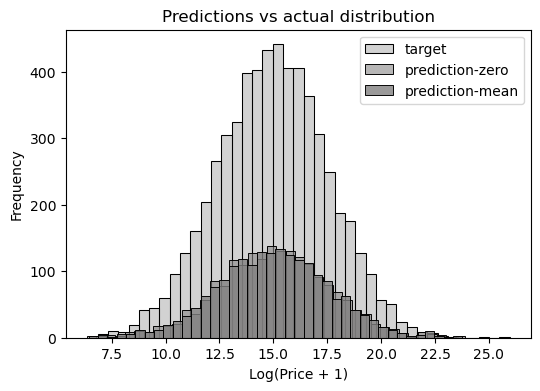

In [235]:
plt.figure(figsize=(6, 4))

sns.histplot(ytrain, label='target', color='#222222', alpha=0.2, bins=40)
sns.histplot(predszero, label='prediction-zero', color="#888686", alpha=0.6, bins=40)
sns.histplot(predsmean, label='prediction-mean', color="#818080", alpha=0.8, bins=40)


plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [277]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [189]:
reg_vals = [0, 0.01, 0.1, 1, 5, 10, 100]
for r in reg_vals:
    w_0, w = train_linear_regression_reg(xtrainzero, ytrainlog, r=r)
    preds = np.expm1(w_0 + xvalzero.dot(w))
    print(f"r: {r}, w0: {w_0}, RMSE: {round(rmse(yval, preds),2)}")


r: 0, w0: 3.6646662474889196, RMSE: 0.62
r: 0.01, w0: 3.168813447098281, RMSE: 0.62
r: 0.1, w0: 1.4288369989600955, RMSE: 0.63
r: 1, w0: 0.2201286194847114, RMSE: 0.64
r: 5, w0: 0.04624885656812594, RMSE: 0.65
r: 10, w0: 0.02327172273186974, RMSE: 0.65
r: 100, w0: 0.0023413689853186695, RMSE: 0.65


Randomizing and creating train, validation and test datasets from scratch for Q5:

In [278]:
def Splitter (df, seed):
    np.random.seed(seed)
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)
    shuf_data = df.iloc[idx]

    xtrain = shuf_data.iloc[:n_train]
    xval = shuf_data.iloc[n_train : n_train + n_val]
    xtest = shuf_data.iloc[n_train + n_val:]

    xtrain = xtrain.reset_index(drop=True)
    xval = xval.reset_index(drop=True)
    xtest = xtest.reset_index(drop=True)

    ytrain = xtrain.fuel_efficiency_mpg.values
    yval = xval.fuel_efficiency_mpg.values
    ytest = xtest.fuel_efficiency_mpg.values

    ytrainlog = np.log1p(xtrain.fuel_efficiency_mpg.values)
    yvallog = np.log1p(xval.fuel_efficiency_mpg.values)
    ytestlog = np.log1p(xtest.fuel_efficiency_mpg.values)

    del xtrain["fuel_efficiency_mpg"]
    del xtest["fuel_efficiency_mpg"]
    del xval["fuel_efficiency_mpg"]

    return xtrain, xval, xtest, ytrain, yval, ytest, ytrainlog, yvallog, ytestlog

In [279]:
def prep (df):
    return df.fillna(0).values

In [215]:
# """
# training on log transformed values
# """

# RMSE = []
# for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
#     X_train, X_val, X_test, y_train, y_val, y_test, y_trainlog, y_vallog, y_testlog = Splitter(sel_data, i)
#     X_train = prep(X_train)
#     X_val = prep(X_val)
#     w_0, w = train_linear_regression(X_train, y_trainlog)
#     predictions = np.expm1(w_0 + X_val.dot(w))
#     RMSE.append(rmse(y_val, predictions))
#     print(f"RMSE value for seed = {i} : {RMSE[i]}")
# print(f"std of RMSE: {round(np.std(RMSE),3)}")

In [260]:
RMSE = []
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    X_train, X_val, X_test, y_train, y_val, y_test, y_trainlog, y_vallog, y_testlog = Splitter(sel_data, i)
    X_train = prep(X_train)
    X_val = prep(X_val)
    w_0, w = train_linear_regression(X_train, y_train)
    predictions = w_0 + X_val.dot(w)
    RMSE.append(rmse(y_val, predictions))
    print(f"RMSE value for seed = {i} : {RMSE[i]}")
print(f"std of RMSE: {round(np.std(RMSE),3)}")

RMSE value for seed = 0 : 0.520653129628249
RMSE value for seed = 1 : 0.521338891285245
RMSE value for seed = 2 : 0.5228069974790945
RMSE value for seed = 3 : 0.5159516741126544
RMSE value for seed = 4 : 0.5109129460051675
RMSE value for seed = 5 : 0.5283406460105421
RMSE value for seed = 6 : 0.5313910658196384
RMSE value for seed = 7 : 0.5090670387410287
RMSE value for seed = 8 : 0.5147399129519323
RMSE value for seed = 9 : 0.5131865908214435
std of RMSE: 0.007


Q6:

In [281]:
X_train, X_val, X_test, y_train, y_val, y_test, y_trainlog, y_vallog, y_testlog = Splitter(sel_data, 9)
new_X_train = pd.concat([X_train, X_val], axis=0)
new_y_train = np.concatenate([y_train, y_val], axis=0)
new_X_train.fillna(0, inplace= True)
X_test.fillna(0, inplace= True)
w_0 ,w = train_linear_regression_reg(new_X_train, new_y_train, r = 0.001)
predictions = w_0 + X_test.dot(w)
print(f"RMSE: {rmse(y_test, predictions)}")


RMSE: 0.5156261299189353
